# Unsupervised Learning Model Evaluation


## Lesson Goals

    Learn about unsupervised model evaluation.
    Calculate silhouette scores for models.
    Determine optimal number of clusters with elbow curves.
    Evaluate cluster quality with Adjusted Rand Score.
    Use visualization techniques to evaluate clusters.


## Introduction

Evaluating an unsupervised machine learning model presents a very tricky problem. With supervised learning, the best metric to use to evaluate a model varied from application to application, but the overall idea is straight-forward - come up with a statistically sound way to compare the model predictions with our known ground truth. With an unsupervised problem, generally speaking we do not have any ground truth labels, so there's no definitive source of truth with which we can compare our model predictions. On some level, this presents an impossible problem - there's no magic bullet or single number that tells us a given unsupervised model is best. Faced with this problem, what are we supposed to do? The answer, unfortunately, is it depends. More specifically, we need to consider what the purpose of our unsupervised learning is, and subjectively analyze it in terms of how well it accomplishes that purpose.

Broadly speaking, unsupervised learning is the process of using algorithms to discover some latent underlying structure in a dataset. In some cases, this is an end unto itself. An e-commerce site might want to make a recommender system that uses shopping history to present new products of interest to users. There's no inherent "right" answer here, but a clustering algorithm that does a better job finding clusters of products that are actually related purchases will be better in this context. In other cases, the unsupervised learning is actually a step in a machine learning pipeline - it finds some underlying structures in the data that can be used as features for a supervised learning system to generate better predictions. In this case, we might judge the performance of the unsupervised model by how much it improves the downstream performance of the supervised model (based on the metric(s) of choice for the supervised model).

Finally, with unsupervised learning models it is important not to discount the role of human intuition and visualizations to evaluate models. Although we have prominent, well-documented cognitive biases and shortcomings, humans are often quite good at recognizing patterns visually and evaluating whether a model "looks right." An important step in evaluating a model is thus often to produce visualizations that highlight some aspect of the model's predictions and see how "right" they look to the human eye. An intuitively similar approach can involve looking at representative samples of members of the clusters/predictions generated by the model. Although this is necessarily a subjective process, it should not be underestimated as a useful tool for evaluation.

Compare the two clustering algorithms on the following example:

![](circles.png)

It is fairly obvious to the human eye that the first algorithm does a better job at identifying the two qualitatively different classes of data present. Although real-world data is rarely this well-behaved, visualization is often one of the best tools we have to make sense of a clustering algorithm.


## Evaluating Quality of Clustering

In the case where we are simply interested in the quality of clustering for its own sake, we have a few tools at our disposal.


## Silhouette Score

This is the closest technique to the relatively simple scoring methods we learned with Supervised Learning. It basically evaluates a model based on how well defined the cluster centers are. For each sample in the dataset, it is defined as:

![](form.png)

where a is the mean distance between the sample and all other points in the same class, and b is the mean distance between the sample and all the other points in the next nearest cluster

For a dataset, we then take the mean Silhouette score for every sample. The score is in the range [-1, 1], with a higher score corresponding to dense, well-separated clusters and scores around 0 indicating overlapping clusters. Scikit-Learn has an implementation:



In [1]:
from sklearn.metrics import silhouette_score

# score = silhouette_score(X, labels, metric='euclidean')

This method is useful because it is straightforward and can be calculated without labels on virtually any clustering problem. However, there are a couple of important caveats:

    The Silhouette score does not say anything, per se, about the usefulness of clusters in a particular
    case. All it says is how well clusters behave in the definitional sense of clusters - e.g. how 
    dense are they and how well separated.

    The score is very similar to the metric that common algorithms like KMeans seek to optimize, so 
    it can lead to overfitting (we are judging a model based on how well it does the exact thing it 
    was trained to do). Having a hold-out test set of data can help with this issue.

    This score favors convex clusters (defined geometrically as clusters where, for every pair of 
    points within the object, every point on the straight line joining them is also within the object). 
    This is fine for data that is amenable to K-Means style clustering, but for many datasets it will 
    give an artificially low score.

**Note**: The metric argument is the distance metric to use. Euclidean distance is the simplest, but it does not work well for high dimensional data.

In the example below, we are generating some data, fitting two clustering models to the data, plotting the clusters assigned by each model, and then printing the silhouette scores for each.

Model 1 Silhouette Score: 0.39228374353167966
Model 2 Silhouette Score: 0.4965775903613271


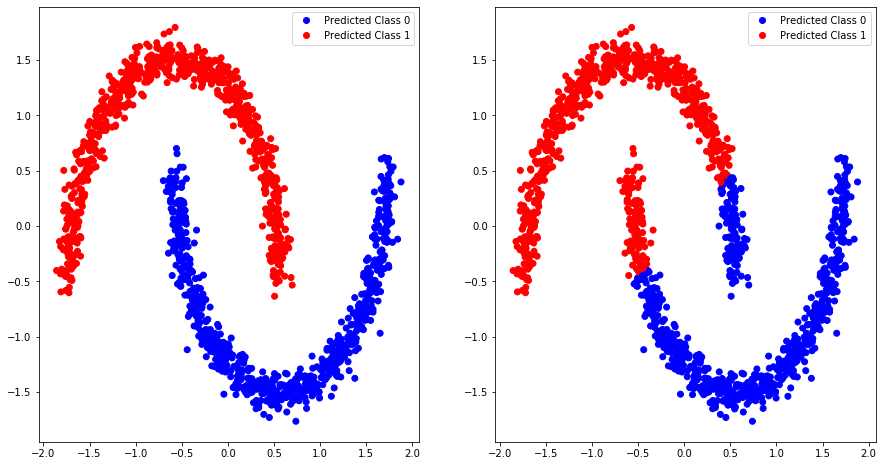

In [2]:
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


n_samples = 1500
X, y = datasets.make_moons(n_samples=n_samples, noise=.05)
X = StandardScaler().fit_transform(X)

single = cluster.AgglomerativeClustering(n_clusters=2, linkage='single')
kmeans = cluster.KMeans(n_clusters=2)
single.fit(X)
y1_pred = single.labels_.astype(np.int)
kmeans.fit(X)
y2_pred = kmeans.predict(X)


fig, ax = plt.subplots(1, 2, figsize=(15, 8))
colors = np.array(['blue', 'red'])
legend_elems = [Line2D([0], [0], color=color, marker='o', linestyle='', label="Predicted Class {}".format(i))
                for i, color in enumerate(colors)]
ax[0].scatter(X[:, 0], X[:, 1], color=colors[y1_pred]);
ax[0].legend(handles=legend_elems, loc='upper right')
ax[1].scatter(X[:, 0], X[:, 1], color=colors[y2_pred]);
ax[1].legend(handles=legend_elems, loc='upper right')

print("Model 1 Silhouette Score: {}".format(silhouette_score(X, y1_pred)))
print("Model 2 Silhouette Score: {}".format(silhouette_score(X, y2_pred)))

As you can see, the second model, based on KMeans and generating convex clusters, has a higher silhouette score, despite doing a qualitatively worse job identifying the clusters in the dataset.

Scikit-Learn also has two other metrics, Calinsky-Harabaz Index and Davies-Bouldin Index which generate similarly "simple" metrics for cluster quality, but generally suffer from the same problems as Silhouette Score.


## Optimal Number of Clusters

When training a clustering algorithm, one of the hardest and most important parameters to optimize is the number of clusters. Having too many clusters might mean that we haven't actually learned much about the data - the whole point of clustering is to identify a relatively small number of similarities that exist in the dataset. Too few clusters might mean that we are grouping unlike samples together artificially. There are many different methods for choosing the appropriate number of clusters, but one common method is calculating a metric (for KMeans usually using its standard sum-of-square-means score function that it tries to minimize) for each number of clusters, then plotting the error function vs the number of clusters.

![](elbow.png)

The optimum number of clusters is often where the plot displays an "elbow" or an inflection point where the slope of the line changes significantly. In this case, we can see an elbow at 3 clusters. Unfortunately, in real world datasets this can sometimes be difficult to ascertain, but it is still a worthwhile thing to look at.

The Yellowbrick machine visualization library has an implementation of an elbow curve visualizer that can be generated as follows. 

In [4]:
!pip install yellowbrick

     |████████████████████████████████| 389kB 213kB/s eta 0:00:01


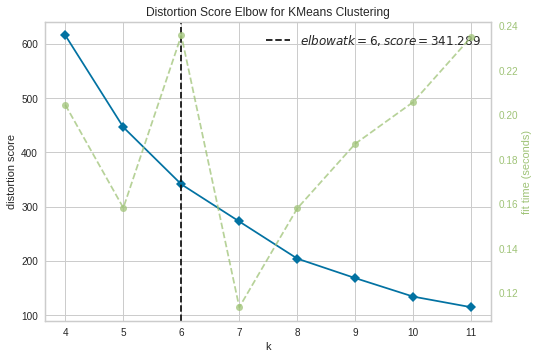

In [5]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(X)
visualizer.poof();

## Other Numerical Approaches

If ground truth (actual labels) are known for a dataset, the options for evaluating the quality of clustering expand dramatically. These methods were often used in research for the development and refinement of clustering algorithms. In these cases, the ground truth labels were either self-evident (the common benchmark MNIST dataset of handwritten digits, for example), or were generated using labor-intensive human experts. Regardless of where the labels come from, a set of labeled data can be held out from the data that the clustering algorithm trains on, then used to evaluate performance, a process known as external evaluation. Scikit-Learn has a number of methods to perform this evaluation, but the most common is the Adjusted Rand Index: 

In [6]:
from sklearn.metrics import adjusted_rand_score

# score = adjusted_rand_score(true_labels, predicted_labels)


It ranges from [-1, 1], with positive being better. It also does not assume a distribution of the underlying clusters either, so will work equally well on convex and non-convex clusters.

In practice, unfortunately, real world datasets for clustering rarely have labels, so this method is of limited use. However, in some problems, you may be able to generate some labels by hand to use as a test set for external evaluation.


## Feature Generation for Supervised Learning

Another way that unsupervised learning is frequently used is to find underlying structures in a dataset that can in turn be used by a supervised learning technique such as Linear Regression to improve prediction results. This can be done for a variety of reasons, but one of the most common is the so-called curse of dimensionality, the phenomena whereby the feature space of a dataset increases so fast that the dataset quickly becomes extremely sparse, creating problems for most statistical methods. A solution to this is to first apply an unsupervised dimensionality reduction model on the dataset, then use the resulting smaller set of features in the classifier/regressor. Another use case is creating more interpretable models; if a classifier is built using clusters as features, the relative importance of these clusters as well as the membership of the clusters can be used to gain insight about how the model is making its predictions.

When using unsupervised learning in this context (creating features for a supervised learning model), we often will use the performance of the derived supervised model to evaluate the quality of the unsupervised model. For the unsupervised model to be useful, it should improve some aspect of performance on the supervised model, so we should be able to use any of the supervised learning model evaluation techniques to compare results with a baseline supervised model that doesn't use the unsupervised-derived features.

## Visualization Techniques

Visualization is extremely important to understanding Unsupervised models. On low dimensional datasets (2-3 dimensions), it is relatively easy to use plots such as those presented earlier in this lesson to evaluate how well a model does at identifying clusters (or outliers) in the data.


## Visualizing Clusters

The most basic visualization we can do is a basic 2-d scatterplot of the data with colors corresponding to clusters. This lets us visually determine whether the clustering algorithm appears to be doing a good job at identifying clusters.

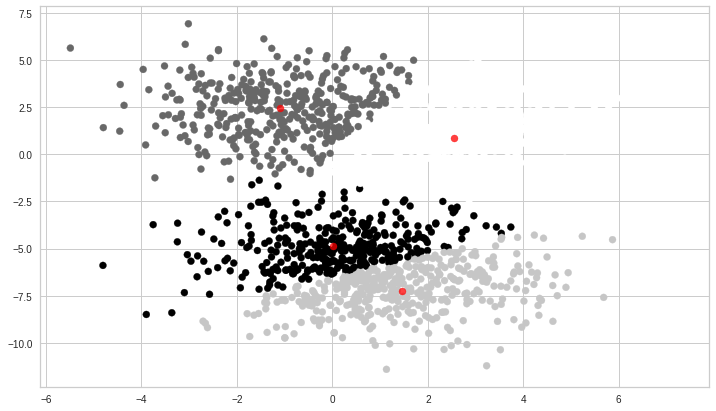

In [7]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, _ = make_blobs(n_samples=1500, centers=4, cluster_std=1.5)

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_pred = kmeans.predict(X)

plt.figure(figsize=(12,7))
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.75)

plt.show();

This can even be done in 3D in a meaningful way, but in the real world we often have much higher dimensionality data. However, not all dimensions are created equal. We might have 10 or 20 features that are inputs for the clustering, but we're really only interested in a few of those features (or perhaps understand from the problem domain that a few are far more influential than others). We can then hand select a few pairs of important features and construct a cluster plot of these pairs to see whether the clustering algorithm is doing a good job discriminating between these paired variables. A bit of a more robust approach is to construct a scatter matrix containing of all pairs of variables and see where the clustering algorithm appears to be doing a good job of differentiating.

These ad-hoc dimensionality reduction approaches do have the problem of assuming clean, differentiable pair-wise patterns in the data. In reality, your dataset might be more complicated than that, and have complex, multi-dimensional decision boundaries that when projected into any given 2 dimensions are not particularly enlightening/clear. Still, looking at pair-wise plots via scatter matrices can be a good exercise for many use cases.


## PCA

Another more sophisticated approach to handling higher dimensional data is a Principal Component Analysis (PCA), which we were introduced to in a previous lesson. A PCA transform attempts to find the orthogonal set of vectors that account for as much of the variability of the dataset in as few components as possible. The first principal component will encompass as much of the dataset variation as possible in 1 dimension, the second component will encompass as much as possible of the remaining variation as possible while remaining orthogonal to the first, and so on. Practically speaking, this means that taking the first n principal components of a dataset captures as much linearly uncorrelated variation as possible.

This intuition can be seen visually:

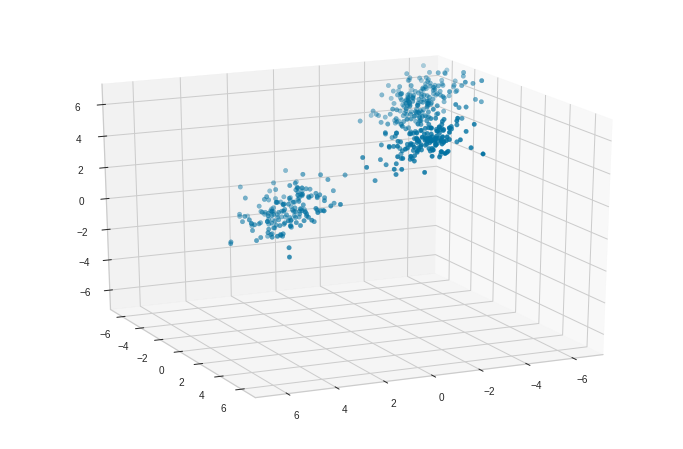

In [8]:
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

X, _ = make_blobs(n_samples=500, n_features=2, centers=3, cluster_std=1.0)

X = np.c_[X, 0.5 * np.random.randn(X.shape[0], 1)]

rot = R.from_euler('y', 45, degrees=True)
X = rot.apply(X)

fig = plt.figure(figsize=(12, 8))
ax = fig.gca(projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2])
ax.set_xlim(-7, 7)
ax.set_ylim(-7, 7)
ax.set_zlim(-7, 7)

ax.view_init(elev=20, azim=65)
plt.show();

In this 3D plot we can see that 3 clusters in the data, but it would be difficult to define these clusters along any of the 3 axes x, y, or z. Now we apply a PCA and plot the components: 

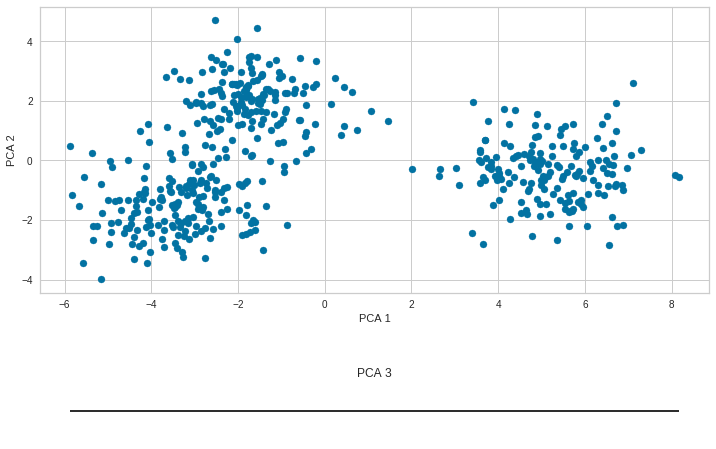

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
pca_X = pca.transform(X)

fig = plt.figure(figsize=(12, 8))
ax = [plt.subplot2grid((6, 1), (0, 0), rowspan=4), plt.subplot2grid((6, 1), (5, 0))]

ax[0].scatter(pca_X[:, 0], pca_X[:, 1])
ax[0].set_xlabel("PCA 1")
ax[0].set_ylabel("PCA 2")

ax[1].set_title('PCA 3', pad=-5)
ax[1].hlines(1, -7, 10)
y = np.ones(X.shape[0])
ax[1].plot(pca_X[:, 2], y, '|', ms='20')
ax[1].axis('off')

plt.show();

As we can see, the PCA transformed us into a vector space where the vast majority of the variation in the data (the 3 clusters generated) are in a 2D space (indeed most of the variation for the 3 clusters could be captured in the first vector, x), and the last PCA component contains relatively little variation.

For datasets that are amenable to linear transforms, PCA can be a powerful method to reduce the dimensionality of the dataset and allow us to make 2 or 3 dimensional plots of higher dimensionality data.


## T-SNE Plots

Another approach to visualizing high-dimensional datasets is t-distributed Stochastic Neighbor Embedding (t-SNE). It is one of the most and widely used of so-called manifold learning techniques which attempt to achieve similar ends as PCA (dimensionality reduction and maximization of variation in orthogonal vectors) for non-linearly separable datasets.

t-SNE uses a complicated algorithm to come up with a 2D representation of data that allows insightful visualization of high dimensional data. The algorithm is adaptive and non-linear, meaning that it can perform different transformations in different areas of the dataset. This allows it to represent both global and local structure faithfully. It also requires a tuning parameter, perplexity, which can be thought of as a balancing act between representing local structure vs. global patterns in the data.

The details of t-SNE are far beyond this lesson, but generally it is worth keeping a few things in mind:

    t-SNE is much more computationally expensive than a linear transform like PCA, so it will run much
    slower, especially on large datasets. One approach to counter this can be to first use PCA to lower 
    the dimensionality of the input data, then run t-SNE on the PCA-transformed output.

    The hyper-parameters (mainly perplexity) can produce different plots, so it is important to run it
    multiple times with different values of perplexity to compare results.

    t-SNE is all about representing clusters in the data. Relative distances and positions of clusters 
    in the visualization may not have significance.


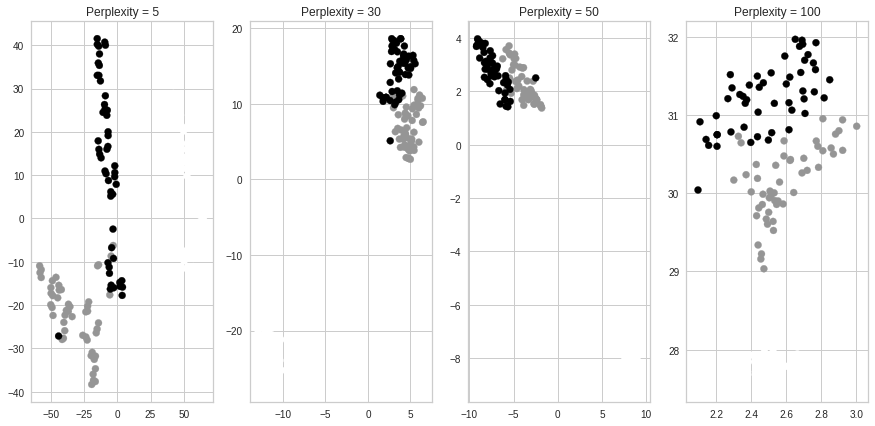

In [10]:
from sklearn.manifold import TSNE

X, y = datasets.load_iris(return_X_y=True)

fig, ax = plt.subplots(1, 4, figsize=(15, 7))
for i, perp in enumerate([5, 30, 50, 100]):
    tsne = TSNE(perplexity=perp)
    x_embedded = tsne.fit_transform(X)
    ax[i].scatter(x_embedded[:, 0], x_embedded[:, 1], c=y)
    ax[i].set_title("Perplexity = {}".format(perp))
    
plt.show();

The output of a t-SNE can be used to visually explore data (to get a sense of the appropriate number of clusters in a high dimensional space, for example), or as the input into another algorithm directly. A clustering algorithm could be applied directly to the output of t-SNE to linearly separate the non-linear clusters in the data it found and build up an accurate or useful unsupervised learning pipeline.